In [1]:
# Necessary imports
from datetime import datetime
import pytz
from copy import deepcopy
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import json
import os
import random

from acnportal import acnsim, algorithms
from acnportal.acnsim import analysis
from acnportal.signals.tariffs import TimeOfUseTariff
from adacharge import *

### Experiment Setupu parameters
Followings are some necessary paramters for the experiment (for simplicity extracted directly)

In [2]:
API_KEY = 'DEMO_TOKEN'
TIMEZONE = pytz.timezone('America/Los_Angeles')
SITE = 'caltech'
PERIOD = 5  # minutes
VOLTAGE = 208  # volts
KW_TO_AMPS = 1000 / 208
KWH_TO_AMP_PERIODS = KW_TO_AMPS * (60 / 5)
MAX_LEN = 144
FORCE_FEASIBLE = True
EVENTS_DIR = "C:\\Users\\s3955218\\repos\\acn-ev-simulation\\events"
VERBOSE = True

In [3]:
def get_events(start, end, ideal_battery, force_feasible, max_len):
    """ Gather Events from ACN-Data with a local cache. """
    # event_name = f"{start}:{end}:{ideal_battery}:{force_feasible}:" \
    #              f"{max_len}"
    event_name = f'simevent_{random.randint(0,9)}'
    path = os.path.join(EVENTS_DIR, event_name + '.json')
    if os.path.exists(path):
        with open(path, 'r') as f:
            return acnsim.EventQueue.from_json(f)
    start_time = TIMEZONE.localize(datetime.strptime(start, '%m-%d-%Y'))
    end_time = TIMEZONE.localize(datetime.strptime(end, '%m-%d-%Y'))
    default_battery_power = 6.656
    if ideal_battery:
        battery_params=None
    else:
        battery_params={'type': acnsim.Linear2StageBattery,
                        'capacity_fn': acnsim.models.battery.batt_cap_fn}
    events = acnsim.acndata_events.generate_events(API_KEY, SITE,
                                                   start_time, end_time,
                                                   PERIOD, VOLTAGE,
                                                   default_battery_power,
                                                   force_feasible=force_feasible,
                                                   max_len=max_len,
                                                   battery_params=battery_params)
    if not os.path.exists(EVENTS_DIR):
        os.mkdir(EVENTS_DIR)
    with open(path, 'w') as f:
        events.to_json(f)
    return events

#### Testing with Events

In [4]:
event_name = "simevent_1"
event_path = os.path.join(EVENTS_DIR, event_name + '.json')

if os.path.exists(event_path):
    with open(event_path, 'r') as f:
        event = acnsim.EventQueue.from_json(f)
        print(event)

acnportal.acnsim.events.event_queue.EventQueue(_queue=<list object at 0x000001C4CAE77D80>, _timestep=0)


### Creating a Wrapper Experiment Class

In [4]:
class Experiment:
    """ Wrapper for ACN-Sim Experiments including caching serialized experiment to disk. """
    def __init__(self, sim):
        self.sim = sim

    def calc_metrics(self):
        """ Calculate metrics from simulation. """
        metrics = {
            'proportion_delivered': analysis.proportion_of_energy_delivered(
                self.sim) * 100,
            'demands_fully_met': analysis.proportion_of_demands_met(
                self.sim) * 100,
            'peak_current': self.sim.peak,
            'demand_charge': analysis.demand_charge(self.sim),
            'energy_cost': analysis.energy_cost(self.sim),
            'total_energy_delivered': analysis.total_energy_delivered(self.sim),
            'total_energy_requested': analysis.total_energy_requested(self.sim)
        }
        return metrics

    def log_local_file(self, path):
        """ Write simulation, metrics and solver statistics to disk. """
        self.sim.to_json(path + 'sim.json')
        with open(path + 'metrics.json', 'w') as outfile:
            json.dump(self.calc_metrics(), outfile)
        with open(path + 'solve_stats.json', 'w') as outfile:
            json.dump(self.sim.scheduler.solve_stats, outfile)

    def run_and_store(self, path):
        """ Run experiment and store results. """
        print(f'Starting - {path}')
        if os.path.exists(path + 'sim.json'):
            print(f'Already Run - {path}...')
            return
        try:
            self.sim.run()
            if not os.path.exists(path):
                os.makedirs(path)
            self.log_local_file(path)
            print(f'Done - {path}')
        except Exception as e:
            print(f'Failed - {path}')
            print(e)

### Simulation configuration 

In [5]:
def configure_sim(
    alg, 
    cap, 
    start, 
    events, 
    basic_evse=True,
    estimate_max_rate=False, 
    uninterrupted_charging=False,
    quantized=False,
    allow_overcharging=False,
    tariff_name=None,
    offline=False
):
    """ Configure simulation. """
    start_time = TIMEZONE.localize(datetime.strptime(start, '%m-%d-%Y'))
        
    if estimate_max_rate:
        alg.max_rate_estimator = algorithms.SimpleRampdown()
        alg.estimate_max_rate = True
    alg.uninterrupted_charging = uninterrupted_charging
    alg.allow_overcharging = allow_overcharging

    # Some algorithms support a quantized option
    if quantized:
        try:
            alg.quantize = True
        except:
            pass
        try:
            alg.reallocate = True
        except:
            pass

    cn = acnsim.sites.caltech_acn(voltage=VOLTAGE,
                                  transformer_cap=cap,
                                  basic_evse=basic_evse)
    if tariff_name is not None:
        signals = {'tariff': TimeOfUseTariff(tariff_name)}
    else:
        signals = {}
    sim = acnsim.Simulator(cn, alg, events, start_time, signals=signals,
                           period=PERIOD, verbose=False)
    
    if offline:
        alg.register_events(events)
        alg.solve()
    
    return sim

### Experiment Configuration
**Note**: For simplicity extracted directly from source

In [6]:
start = '9-1-2018'
end = '10-1-2018'
tariff_name = 'sce_tou_ev_4_march_2019'
revenue = 0.3
# Scenario I is the offline optimal.
scenarios = {
                'II': {'ideal_battery': True,
                      'estimate_max_rate': False,
                      'uninterrupted_charging': False,
                      'quantized': False,
                      'basic_evse': True
                },
                'III': {'ideal_battery': True,
                       'estimate_max_rate': False,
                       'uninterrupted_charging': True,
                       'quantized': True,
                       'basic_evse': False
                },
                # 'IV': {'ideal_battery': False,
                #         'estimate_max_rate': True,
                #         'uninterrupted_charging': False,
                #         'quantized': False,
                #         'basic_evse': True
                # },
                # 'V': {'ideal_battery': False,
                #        'estimate_max_rate': True,
                #        'uninterrupted_charging': True,
                #        'quantized': True,
                #        'basic_evse': False
                # },
}

### Energy Delivered with constrained infrastructure 

In [7]:
energy_del_base_dir = "C:\\Users\\s3955218\\repos\\acn-ev-simulation\\results\\infrastructure_utilization_results"

### Running Simulation
- Maximizing total energy delivered when infrastructure is oversubscribed
- Electricity prices are static or user statisfaction is the primary concern

Utility Function:
$$
    {U^{QC}(r)} := u^{QC}(r) + 10^{-12}u^{ES}(r)
$$

Here $U^{QC}$ encourages the system to deliver energy as quickly as possible, which helps free capacity for future arrivals. The regularizer ${u^{ES}(r)}$ promotes equal sharing between similar EVs and force a unique solution.

In [18]:
ALGS = dict()
ALGS['LLF'] = algorithms.SortedSchedulingAlgo(algorithms.least_laxity_first)
# ALGS['EDF'] = algorithms.SortedSchedulingAlgo(algorithms.earliest_deadline_first)
ALGS['RR'] = algorithms.RoundRobin(algorithms.first_come_first_served, continuous_inc=1)

quick_charge_obj = [
    ObjectiveComponent(quick_charge),
    ObjectiveComponent(equal_share, 1e-12)
]
ALGS['ASA-QC'] = AdaptiveSchedulingAlgorithm(quick_charge_obj,
                                             solver='MOSEK',
                                             max_recompute=1)

In [19]:
# Online Algorithms
caps = [80, 150]
for scenario_id, scenario in scenarios.items():
    for cap in caps:
        for alg in ['ASA-QC', 'RR', 'LLF']:
            output_dir = f'{energy_del_base_dir}\\{cap}\\{alg}\\'
            events = get_events(start, end, scenario['ideal_battery'], FORCE_FEASIBLE, MAX_LEN)

            sim = configure_sim(
                cap=cap,
                alg=deepcopy(ALGS[alg]),
                start=start,
                events=events,
                basic_evse=scenario['basic_evse'],
                estimate_max_rate=scenario['estimate_max_rate'],
                uninterrupted_charging=scenario['uninterrupted_charging'],
                quantized=scenario['quantized'],
                tariff_name=tariff_name
            )
            ex = Experiment(sim)
            ex.run_and_store(output_dir)

Starting - C:\Users\s3955218\repos\acn-ev-simulation\results\infrastructure_utilization_results\80\ASA-QC\
Already Run - C:\Users\s3955218\repos\acn-ev-simulation\results\infrastructure_utilization_results\80\ASA-QC\...
Starting - C:\Users\s3955218\repos\acn-ev-simulation\results\infrastructure_utilization_results\80\RR\
Already Run - C:\Users\s3955218\repos\acn-ev-simulation\results\infrastructure_utilization_results\80\RR\...
Starting - C:\Users\s3955218\repos\acn-ev-simulation\results\infrastructure_utilization_results\80\LLF\


c:\Users\s3955218\Anaconda3\envs\acnsim\lib\site-packages\acnportal\acnsim\simulator.py:387: UserWarning: Not serializing signals as value typesare not natively JSON serializable.
  warnings.warn(


Done - C:\Users\s3955218\repos\acn-ev-simulation\results\infrastructure_utilization_results\80\LLF\
Starting - C:\Users\s3955218\repos\acn-ev-simulation\results\infrastructure_utilization_results\150\ASA-QC\
Already Run - C:\Users\s3955218\repos\acn-ev-simulation\results\infrastructure_utilization_results\150\ASA-QC\...
Starting - C:\Users\s3955218\repos\acn-ev-simulation\results\infrastructure_utilization_results\150\RR\
Already Run - C:\Users\s3955218\repos\acn-ev-simulation\results\infrastructure_utilization_results\150\RR\...
Starting - C:\Users\s3955218\repos\acn-ev-simulation\results\infrastructure_utilization_results\150\LLF\
Done - C:\Users\s3955218\repos\acn-ev-simulation\results\infrastructure_utilization_results\150\LLF\
Starting - C:\Users\s3955218\repos\acn-ev-simulation\results\infrastructure_utilization_results\80\ASA-QC\
Already Run - C:\Users\s3955218\repos\acn-ev-simulation\results\infrastructure_utilization_results\80\ASA-QC\...
Starting - C:\Users\s3955218\repos\acn

Maximum energy that could be delivered can be calculated by solving following optimization problem. This is considered as *Offline Optimal* solution. Here, $\mathcal{V}$ includes all EVs, not just those present at time $k$. We also modify the constraints so that EVs cannot charge before their arrival time.
\begin{equation*}
    U^\mathrm{EM\_OFF}(r) :=  \sum_{\substack{t \in \mathcal{T}\\i \in \mathcal{V}}} r_i(t)
\end{equation*}

In [11]:
# Offline Optimal
optimal_obj = [ObjectiveComponent(total_energy)]
optimal_alg = AdaptiveChargingAlgorithmOffline(optimal_obj, solver='MOSEK')
for cap in caps:
    output_dir = f'{energy_del_base_dir}\\{cap}\\Optimal\\'
    events = get_events(start, end, True, FORCE_FEASIBLE, MAX_LEN)

    sim = configure_sim(
        cap=cap,
        alg=deepcopy(optimal_alg),
        start=start,
        events=events,
        basic_evse=True,
        estimate_max_rate=False,
        uninterrupted_charging=False,
        quantized=False,
        tariff_name=tariff_name,
        offline=True
    )
    ex = Experiment(sim)
    ex.run_and_store(output_dir)

Starting - C:\Users\s3955218\repos\acn-ev-simulation\results\infrastructure_utilization_results\80\Optimal\


c:\Users\s3955218\Anaconda3\envs\acnsim\lib\site-packages\acnportal\acnsim\simulator.py:387: UserWarning: Not serializing signals as value typesare not natively JSON serializable.
  warnings.warn(


Done - C:\Users\s3955218\repos\acn-ev-simulation\results\infrastructure_utilization_results\80\Optimal\
Starting - C:\Users\s3955218\repos\acn-ev-simulation\results\infrastructure_utilization_results\150\Optimal\
Done - C:\Users\s3955218\repos\acn-ev-simulation\results\infrastructure_utilization_results\150\Optimal\


### Analysis

In [20]:
def get_metric(results_dir, config, metric_name):
    # path = os.path.join(results_dir, f"{config['start']}:{config['end']}", config['scenario'],
    #            str(config['cap']), config['alg'], 'metrics.json')
    path = os.path.join(results_dir, str(config['cap']), config['alg'], 'metrics.json')
    if not os.path.exists(path):
        return float('nan')
    with open(path) as f:
        metrics = json.load(f)
    if metric_name is None:
        return metrics
    else:   
        return metrics[metric_name]

def get_solve_stats(results_dir, config):
    # path = os.path.join(results_dir, f"{config['start']}:{config['end']}", config['scenario'],
    #            str(config['cap']), config['alg'], 'solve_stats.json')
    path = os.path.join(results_dir, str(config['cap']), config['alg'], 'solve_stats.json')
    if not os.path.exists(path):
        return float('nan')
    with open(path) as f:
        return json.load(f)

def get_sim(results_dir, config):
    path = os.path.join(results_dir, f"{config['start']}:{config['end']}", config['scenario'],
               str(config['cap']), config['alg'], 'sim.json')
    if not os.path.exists(path):
        return None
    with open(path) as f:
        try:
            return acnsim.Simulator.from_json(f)
        except:
            print(path)

In [65]:
start = '9-1-2018'
end = '10-1-2018'
caps = [80, 150]
algs = ['ASA-QC', 'RR', 'LLF']
scenario_order = ['II', 'III']
percent_del = dict()

percent_del['Optimal'] = np.full((1, len(caps)), np.nan)
for col, cap in enumerate(caps):
    config = {'scenario': 'I', 'start': start, 'end': end, 'cap': cap, 'alg': 'Optimal'}
    percent_del['Optimal'][0, col] = get_metric(f'{energy_del_base_dir}\\', config, 'proportion_delivered')

for scenario in scenario_order:
    percent_del[scenario] = np.full((len(algs), len(caps)), np.nan)
    for row, alg in enumerate(algs):
        for col, cap in enumerate(caps):
            config = {'scenario': scenario, 'start': start, 'end': end, 'cap': cap, 'alg': alg}
            percent_del[scenario][row, col] = get_metric(f'{energy_del_base_dir}\\', config, 'proportion_delivered')

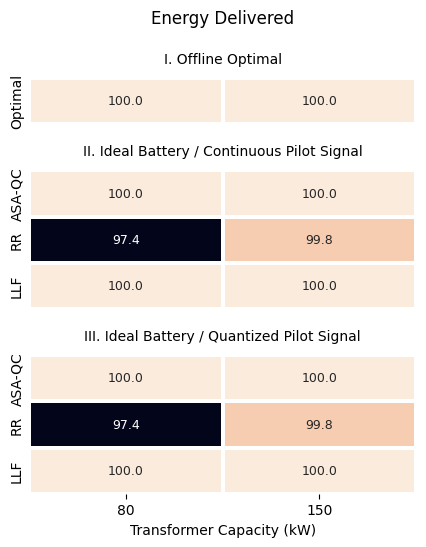

In [84]:
fig, ax = plt.subplots()
ax.set_title("Energy Delivered")


fig.set_size_inches(5, 6)
# labels = ['', 'Optimal',
#           '', 'ASA-QC', 'LLF', 'EDF', 'RR',
#           '', 'ASA-QC', 'LLF', 'EDF', 'RR',
#           '', 'ASA-QC', 'LLF', 'EDF', 'RR',
#           '', 'ASA-QC', 'LLF', 'EDF', 'RR']

# Alternate labels
labels = ['', 'Optimal',
          '', 'ASA-QC', 'RR', 'LLF',
          '', 'ASA-QC', 'RR', 'LLF'
         ]

spacer = np.full((1, len(caps)), np.nan)
stack = [spacer]
stack.append(percent_del['Optimal'])
for scenario in scenarios:
    stack.append(spacer)
    stack.append(percent_del[scenario])
heatmap = np.vstack(stack)


sns.heatmap(heatmap, annot=True, fmt='.1f', linewidth=1.5, ax=ax,
            cbar=False, annot_kws= {'fontsize':9}, yticklabels=labels, xticklabels=caps)
title_style = {'horizontalalignment': 'center', 'verticalalignment': 'center', 'fontsize': 10}
vert_offset = 0.6
ax.text(1, 0 + vert_offset, 'I. Offline Optimal', **title_style)
ax.text(1, 2 + vert_offset, 'II. Ideal Battery / Continuous Pilot Signal', **title_style)
ax.text(1, 6 + vert_offset, 'III. Ideal Battery / Quantized Pilot Signal', **title_style)
# ax.text(4, 12 + vert_offset, 'IV. Non-Ideal Battery / Continuous Pilot Signal', **title_style)
# ax.text(4, 17 + vert_offset, 'V. Non-Ideal Battery / Quantized Pilot Signal', **title_style)
ax.set_xlabel('Transformer Capacity (kW)')
ax.axvline(6.99, 21/22, 20/22, color='k', linewidth=0.5)
ax.axvline(6.99, 19/22, 15/22, color='k', linewidth=0.5)
ax.axvline(6.99, 19/22, 15/22, color='k', linewidth=0.5)
# ax.axvline(6.99, 14/22, 10/22, color='k', linewidth=0.5)
# ax.axvline(6.99, 9/22, 5/22, color='k', linewidth=0.5)
# ax.axvline(6.99, 4/22, 0/22, color='k', linewidth=0.5)

ax.tick_params(axis=u'y', which=u'both',length=0)
# fig.tight_layout();

In [85]:
fig.savefig(f"C:\\Users\s3955218\\OneDrive - RMIT University\\Research Milestones\\CoC\simulation_others\\perc_energy_delivered.tiff", dpi=300)

In [98]:
start = '9-1-2018'
end = '10-1-2018'
# caps = list(range(20, 81, 10)) + [150]
caps = [80, 150]
# scenario_order = ['II', 'III', 'IV', 'V']
scenario_order = ['II', 'III']
algs = ['ASA-QC', 'RR', 'LLF']
avg_solve_time = dict()
for scenario in scenario_order:
    avg_solve_time[scenario] = np.full((len(algs), len(caps)), np.nan)
    for row, alg in enumerate(algs):
        for col, cap in enumerate(caps):
            config = {'scenario': scenario, 'start': start, 'end': end,
                      'cap': cap, 'alg': alg}
            try:
                stats = pd.DataFrame(get_solve_stats(f'{energy_del_base_dir}\\', config))
                stats = stats[stats['active_sessions'] > 25]
                avg_solve_time[scenario][row, col] = stats['solve_time'].mean()
            except:
                pass

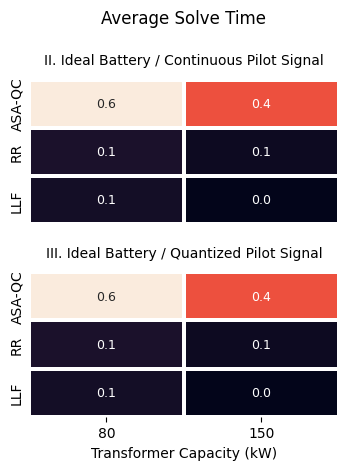

In [106]:
fig, ax = plt.subplots()
ax.set_title("Average Solve Time")
fig.set_size_inches(4, 5)
labels = ['', 'ASA-QC', 'RR', 'LLF',
          '', 'ASA-QC', 'RR', 'LLF'
          ]

stack = []
spacer = np.full((1, len(caps)), np.nan)
for scenario in scenarios:
    stack.append(spacer)
    stack.append(avg_solve_time[scenario])
heatmap = np.vstack(stack)


sns.heatmap(heatmap, annot=True, fmt='.1f', linewidth=1.5, ax=ax,
            cbar=False, annot_kws= {'fontsize':9}, yticklabels=labels, xticklabels=caps)
title_style = {'horizontalalignment': 'center', 'verticalalignment': 'center', 'fontsize': 10}
vert_offset = 0.6
ax.text(1, 0 + vert_offset, 'II. Ideal Battery / Continuous Pilot Signal', **title_style)
ax.text(1, 4+ vert_offset, 'III. Ideal Battery / Quantized Pilot Signal', **title_style)
# ax.text(4, 10 + vert_offset, 'IV. Non-Ideal Battery / Continuous Pilot Signal', **title_style)
# ax.text(4, 15 + vert_offset, 'V. Non-Ideal Battery / Quantized Pilot Signal', **title_style)
ax.set_xlabel('Transformer Capacity (kW)')

ax.tick_params(axis=u'y', which=u'both',length=0)
# fig.tight_layout();

In [107]:
fig.savefig(f"C:\\Users\s3955218\\OneDrive - RMIT University\\Research Milestones\\CoC\simulation_others\\avg_solve_time.tiff", dpi=300)